In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import more_itertools as mit

In [6]:
attnResult = np.load('./AttnBi-LSTM.npy')
lstmResult = np.load('./lstmEncDnc_yHat.npy')
data = pd.read_csv('../data/nyc_taxi.csv')
train = pd.read_csv('../data/nyc_taxi_train.csv')
test = pd.read_csv('../data/nyc_taxi_test.csv')
print('attnResult.shape',attnResult.shape)
print('lstmResult.shape',lstmResult.shape)
ground_truth = test.values[::,3][-949:]
max_num = np.array([39197.])
min_num = np.array([8.])
interval = (max_num-min_num)/2
mean = (max_num+min_num)/2
attnResult = attnResult * interval + mean
attnResult = attnResult.reshape(-1)
lstmResult = lstmResult * interval + mean
lstmResult = lstmResult.reshape(-1)

attnResult.shape (949, 1)
lstmResult.shape (949, 1)


In [14]:
def get_errors(y_test,y_hat,smoothed=True):
    
    #考虑一下是否需要进行多级平滑
    
    assert y_test.shape == y_hat.shape
    
    residual = np.abs(y_test-y_hat)
    if not smoothed:return residual
    
    smooth_window = 50*32*0.05  
    smooth_residual = pd.DataFrame(residual).ewm(span=smooth_window).mean().values.flatten().tolist()
    return smooth_residual

es = get_errors(ground_truth,attnResult,smoothed=True)

/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


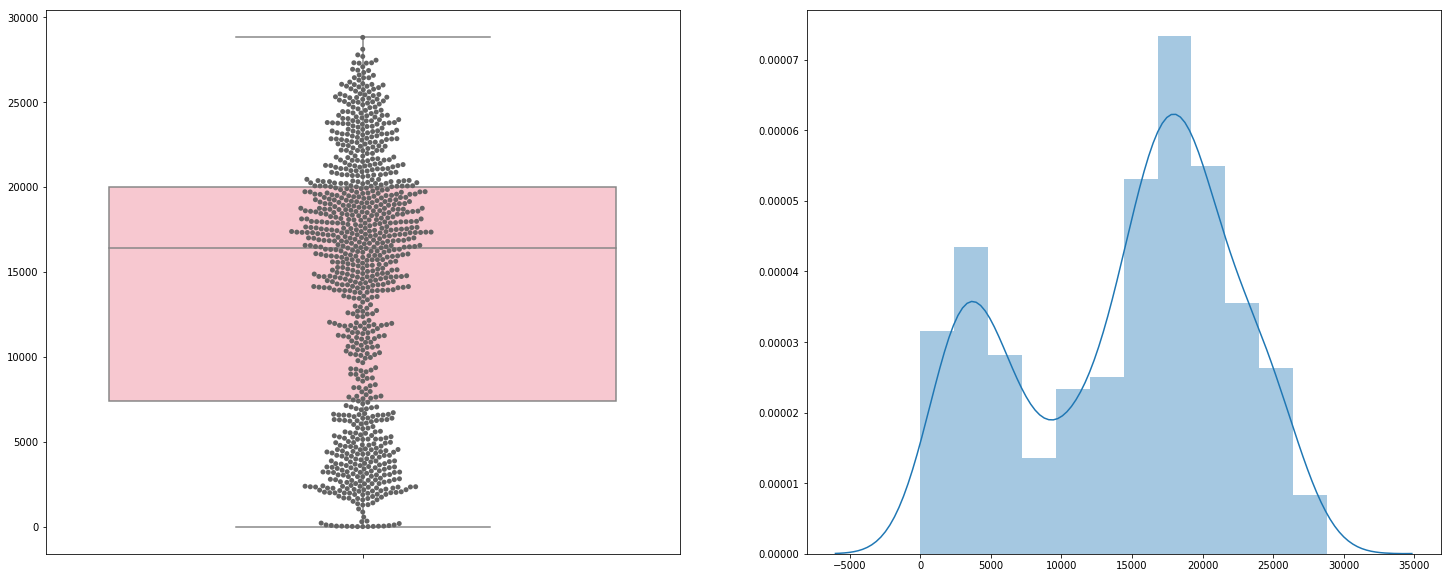

'\n上四分位 --> U 表示的是所有样本中只有1/4的值大于U\n下四分位 --> L \n上四分位与下四分位的插值 --> IQR = U-L\n上界 U+1.5IQR\n下界 L-1.5IQR\n'

In [86]:
##y_test箱形图分析
plt.figure(figsize=(25,10))
plt.subplot(121)
sns.boxplot(y=ground_truth.tolist(),color = 'pink')
sns.swarmplot(y=ground_truth.tolist(),color = '.39')
plt.subplot(122)
sns.violinplot(x="day", y="total_bill", hue="time", split=True, data=tips)
sns.distplot(ground_truth.tolist())
plt.show()

'''
上四分位 --> U 表示的是所有样本中只有1/4的值大于U
下四分位 --> L 
上四分位与下四分位的插值 --> IQR = U-L
上界 U+1.5IQR
下界 L-1.5IQR
'''

In [67]:
def find_epsilon(es,r,limit):
    mean = np.mean(es)
    sd = np.std(es)
    
    max_s = 0
    sd_threshold = limit
    
    for z in np.arange(1,sd_threshold,0.5):
        epsilon = mean + (sd*z)
        normal_es,normal_idx,anom_idx = [],[],[]
        
        for idx,e in enumerate(es):
            if e <= epsilon:
                normal_es.append(e)
                normal_idx.append(idx)
            if e > epsilon:
                for j in range(0,r):
                    if not idx+j in anom_idx and not idx+j >= len(es):
                        anom_idx.append(idx+j)
                    if not idx-j in anom_idx and not idx-j < 0:
                        anom_idx.append(idx-j)
        if len(anom_idx)>0:
            anom_idx = sorted(list(set(anom_idx)))
            groups = [list(group) for group in mit.consecutive_groups(anom_idx)]
            e_seq = [(g[0],g[-1]) for g in groups if not g[0]==g[-1]]
#             print('>>> e_seq in %d epoch:'%z)
#             print('>>> e_seq : ',e_seq)
            
            mean_perc_decrease = (mean-np.mean(normal_es)) / mean
            sd_perc_decrease = (sd - np.std(normal_es)) / sd
            
            s = (mean_perc_decrease + sd_perc_decrease) / (len(e_seq)**2 + len(anom_idx))
#             print('>>> s value:',s)
            if s >= max_s and len(anom_idx) < len(es)*0.5:
                sd_threshold = z
                max_s = s
    return sd_threshold
epsilon = find_epsilon(es,r=48,limit=10)

In [73]:
def compare_to_epsilon(es,epsilon,len_y_test,inter_range,
                       test_std,std,r,window,anom_full_idx):
    anom_idx,e_seq,non_anom_max = [],[],0
    
    #最后的条件应该改一下
#     if not (std > 0.05*chan_std) or max(es) > (0.05*inter_range) or not max(e_s) > 0.05:
#         return e_seq,anom_idx,non_anom_max

    num_to_ignore = 0
    
    for x in range(0,len(es)):
        anom = True
        if not es[x] > epsilon or not es[x] >0.05 *inter_range:
            anom = False
        if anom:
            for b in range(0,r):
                if not x+b in anom_idx and not x+b >= len(es) and (x+b >= len(es) - 32 or window == 0):
                    if not (window == 0 and x+b < num_to_ignore):
                        anom_idx.append(x+b)
                if not x-b in anom_idx and (x-b > len(es)- 32 or window ==0):
                    anom_idx.append(x-b)
    for x in range(0,len(es)):
        adjusted_x = x + window*32
        if es[x] > non_anom_max and not adjusted_x in anom_full_idx and not x in anom_idx:
            non_anom_max = es[x]
    
    anom_idx = sorted(list(set(anom_idx)))
    groups = [list(group) for group in mit.consecutive_groups(anom_idx)]
    e_seq = [(g[0],g[-1]) for g in groups if not g[0]==g[-1]]
    return  e_seq,anom_idx,non_anom_max

In [77]:
def prune_anoms(e_seq,es,non_anom_max,anom_idx):
    e_seq_max,es_max = [],[]
    for seq in e_seq:
        if seq[0]<0:
            seq[0] = 0
        elif seq[1]>len(es):
            seq[1] = len(es)-1
            
        if len(es[seq[0]:es[seq[1]]]) > 0:
            e_seq_max.append(max(es[seq[0]:seq[1]]))
            es_max.append(max(es[seq[0]:seq[1]]))
    es_max.sort(reverse=True)
    if non_anom_max >0:
        es_max.append(non_anom_max)
        
    i_to_remove = []
    p = 0.1
    
    for i in range(0,len(es_max)):
        if i+1 < len(es_max):
            if (es_max[i] - es_max[i+1]) / es_max[i] < p:
                i_to_remove.append(e_seq_max.index(es_max[i]))
                
            else:
                i_to_remove = []
        
    for idx in sorted(i_to_remove,reverse=True):
        del e_seq[idx]
        
    i_pruned = []
    for i in i_anom:
        keep_anomaly_idx = False
        
        for seq in e_seq:
            if i >= seq[0] and i <= seq[1]:
                keep_anomaly_idx = True
        
        if keep_anomaly_idx == True:
            i_pruned.append(i)
            
    return i_pruned
    
            

In [84]:
def get_anomalies(es,y_test,z,window):
    perc_high,perc_low = np.percentile(y_test,[90,10])
    inter_range = perc_high-perc_low 
    
    mean = np.mean(es)
    std = np.std(es)
    test_std = np.std(y_test)
    
    es_inv = [mean + (mean-e) for e in es]
    z_inv = find_epsilon(es_inv,48,10)
    epsilon = mean + float(z)*std
    epsilon_inv = mean + float(z_inv)*std
    
    e_seq,anom_idx,non_anom_max = compare_to_epsilon(es,epsilon,len(y_test),inter_range,test_std,std,48,0,[])
    e_seq_inv,anom_idx_inv,non_anom_max_inv =  compare_to_epsilon(es_inv,epsilon_inv,len(y_test),inter_range,test_std,std,48,0,[])
    
    
#     if len(e_seq) > 0:
#         anom_idx = prune_anoms(e_seq,es,non_anom_max,anom_idx)
#     if len(e_seq_inv) > 0:
#         anom_idx_inv = prune_anoms(e_seq_inv,es_inv,non_anom_max_inv,anom_inv_idx)
        
#     anom_idx = list(set(anom_idx + anom_idx_inv))
    
    return e_seq
    
    
get_anomalies(es,ground_truth,epsilon,0)

[(-44, 54), (668, 784)]